# Result_Fig2_2 : Difficulty with Tag Availability

In [1]:
# create table tt_tag_proportion as
# select to_char(xx.creationdate, 'yyyy-mm-dd') as cdate , xx.id, xx.tag, xx.cnt, yy.tot_cnt, xx.cnt::FLOAT /yy.tot_cnt as pct
#   from (
#        select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag, 1 as cnt
#         from public.posts
#         where posttypeid = '1'
#           and creationdate between '2021-11-30' and '2023-12-01'
#           and tags like '%<python>%'

#            ) xx,
#        (
#            select x.id, count(x.tag) as tot_cnt
#               from (select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag
#                       from public.posts
#                     where posttypeid = '1'
#                       and creationdate between '2021-11-30' and '2023-12-01'
#                       and tags like '%<python>%') x
#             group by x.id

#            )yy
# where xx.id = yy.id
# ;

In [2]:
import sys, os
p = os.path.abspath('..')
sys.path.insert(1, p)

In [ ]:
import lib.stats.stats as st
from utils.statistics import *
from lib.distribution_collector import (collect_tag_distributions)
from constants import CONSTANTS
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import psycopg2
import pandas as pd
import numpy as np
from utils.statistics import *
import config.config as conf
import datetime

import numpy as np
import pandas as pd


In [4]:
output_dir = './fig/'

In [5]:
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute("\
           select * \
           from tt_tag_proportion a \
; \
                " 
   )
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [6]:
df = pd.DataFrame(rows, columns = [
  'cdate' 
, 'id' 
, 'tag'
, 'cnt'
, 'tot_cnt'
, 'pct'
])

In [7]:
std_date = datetime.datetime(2022, 11, 30)
pre_std_date = datetime.datetime(2021, 12, 1)

In [8]:
df['cdate'] = pd.to_datetime(df['cdate'], format="%Y-%m-%d")

In [9]:
df['rel_week'] = np.floor((df['cdate']-std_date).dt.days/7)

In [10]:
# 상위, 하위 태그 리스트 추출
df_bf_pro = df[df['rel_week']<0].groupby(['tag']).sum(['pct'])['pct'].sort_values().reset_index()
tagnum = int(np.floor(df_bf_pro.shape[0]*0.2))
bot_tag = list(df_bf_pro.iloc[:tagnum, 0])
top_tag = list(df_bf_pro.iloc[tagnum:, 0])

In [11]:
# stackedbar를 위한 계산 수행 (전체 대비 비율 계산 및 주차별 합산 계산)
df_tot = df.groupby(['rel_week']).sum(['pct'])['pct'].reset_index(name = 'tot_pct')
df_pct = pd.merge(df, df_tot, on = 'rel_week')

df_pct['pct_pct'] = df_pct['pct']/df_pct['tot_pct']

df_pct_bot = df_pct[df_pct['tag'].isin(bot_tag)]
df_pct_top = df_pct[df_pct['tag'].isin(top_tag)]

df_pct_top_tot = df_pct_top.groupby(['rel_week']).sum(['pct_pct'])['pct_pct'].reset_index()
df_pct_bot_tot = df_pct_bot.groupby(['rel_week']).sum(['pct_pct'])['pct_pct'].reset_index()


In [12]:
proportion_dict = {'Top 20% Tags' : df_pct_top_tot
                ,   'Bottom 20% Tags' : df_pct_bot_tot}

In [13]:
tag_info = f"{CONSTANTS.data_availability_dir}/result/tag/tag_info.json" 
tag_dir = f"{CONSTANTS.data_availability_dir}/{CONSTANTS.tag_monthly_data_dir[3:]}"
output_dir = './fig/'

In [14]:
tag_distributions = collect_tag_distributions(window=7,
                                            tag_info = tag_info,
                                            data_dir=tag_dir,
                                            options=None)
    

<class 'dict'>
['2021-12-01 00:00:00', '2021-12-08 00:00:00', '2021-12-15 00:00:00', '2021-12-22 00:00:00', '2021-12-29 00:00:00', '2022-01-05 00:00:00', '2022-01-12 00:00:00', '2022-01-19 00:00:00', '2022-01-26 00:00:00', '2022-02-02 00:00:00', '2022-02-09 00:00:00', '2022-02-16 00:00:00', '2022-02-23 00:00:00', '2022-03-02 00:00:00', '2022-03-09 00:00:00', '2022-03-16 00:00:00', '2022-03-23 00:00:00', '2022-03-30 00:00:00', '2022-04-06 00:00:00', '2022-04-13 00:00:00', '2022-04-20 00:00:00', '2022-04-27 00:00:00', '2022-05-04 00:00:00', '2022-05-11 00:00:00', '2022-05-18 00:00:00', '2022-05-25 00:00:00', '2022-06-01 00:00:00', '2022-06-08 00:00:00', '2022-06-15 00:00:00', '2022-06-22 00:00:00', '2022-06-29 00:00:00', '2022-07-06 00:00:00', '2022-07-13 00:00:00', '2022-07-20 00:00:00', '2022-07-27 00:00:00', '2022-08-03 00:00:00', '2022-08-10 00:00:00', '2022-08-17 00:00:00', '2022-08-24 00:00:00', '2022-08-31 00:00:00', '2022-09-07 00:00:00', '2022-09-14 00:00:00', '2022-09-21 00:00:

In [15]:
ginis = list(map(lambda x: calculate_gini(list(x.values())), tag_distributions))

In [16]:
entropies = list(map(lambda x: calculate_entropy(list(x.values())), tag_distributions))

In [17]:
gini_entropy_dict = {'Gini Coefficient' : ginis, 'Entropy' : entropies}

In [18]:
rel_week = np.array(np.arange(-52, 52))

In [19]:
st_0 = st.Stats(rel_week, entropies, 2, 0.95)

In [20]:
F_stat_0, p_value_0 = st_0.chow_test()

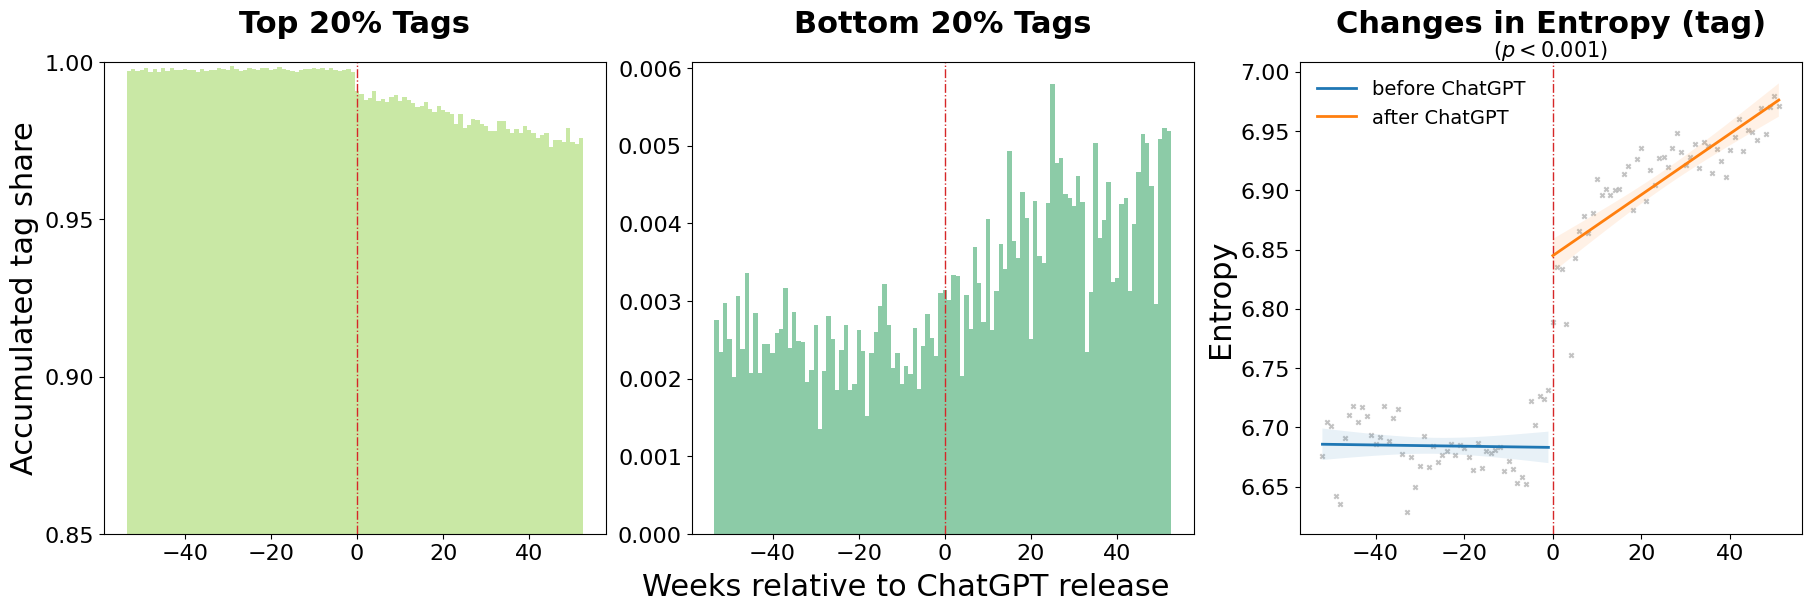

In [21]:
sharey = False 
sharex = True 
g_num  = len(proportion_dict.items())

fig, axs = plt.subplots(1, 3, figsize = (18, 6), constrained_layout=True)
alpha_list = [0.6, 0.5]
color_list = ["#a6d96a", "#1a9850"]

for x, (title, proportion) in enumerate(proportion_dict.items()):
    rel_week = list(proportion['rel_week'])
    values = list(proportion['pct_pct'])
    
    axs[x].bar(rel_week, values, color=color_list[x], width=1.0, align='center', alpha=alpha_list[x]
    )
    axs[x].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)

    if x ==0 :
        axs[x].set_ylim(0.85, 1.0)
        axs[x].set_yticks(np.arange(0.85, 1.01, 0.05))

    # axs[x].set_title(f'{title}', fontsize=25)

    axs[x].text(0.5, 1.05, f"{title}",
            ha='center', va='bottom', fontsize=22, fontweight='bold', transform=axs[x].transAxes)

    axs[x].text(0.5, 1.00, "",
        ha='center', va='bottom', fontsize=15, transform=axs[x].transAxes)  
    axs[x].tick_params(axis='x', labelsize=16)
    axs[x].tick_params(axis='y', labelsize=16)


# for idx, measure in enumerate(gini_entropy_dict.keys()):
#     idx+=2
# entropy만 시각화
idx = 2
list_ = gini_entropy_dict['Entropy']
x_rel, divider = get_dist_x_div(list_)

reg_bf = calc_regression_with_ci(x_rel[:divider], list_[:divider])
reg_af = calc_regression_with_ci(x_rel[divider:], list_[divider:])

reg_bf_summary = reg_bf["pred_summary"]
reg_af_summary = reg_af["pred_summary"]

# 회귀선 (예측값)
reg_bf_y_pred = reg_bf_summary["mean"]
reg_af_y_pred = reg_af_summary["mean"]
# 신뢰구간
reg_bf_ci_lower = reg_bf_summary["mean_ci_lower"]
reg_bf_ci_upper = reg_bf_summary["mean_ci_upper"]

reg_af_ci_lower = reg_af_summary["mean_ci_lower"]
reg_af_ci_upper = reg_af_summary["mean_ci_upper"]

p_value_txt = '($p < 0.001$)' if p_value_0 <0.001 else '($p = {p_value_0:.3f}$)'

axs[idx].scatter(x_rel, list_, color = 'darkgray', alpha = 0.7,  s=10, marker='x')
axs[idx].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)
# axs[idx].set_ylabel(f"{measure} of Topic Distribution", fontsize = 10)
axs[idx].plot(x_rel[:divider], reg_bf_y_pred, linewidth=2, label = 'before ChatGPT')
axs[idx].plot(x_rel[divider:], reg_af_y_pred, linewidth=2, label = 'after ChatGPT')

axs[idx].fill_between(x_rel[:divider], reg_bf_ci_lower, reg_bf_ci_upper, alpha=0.1)
axs[idx].fill_between(x_rel[divider:], reg_af_ci_lower, reg_af_ci_upper, alpha=0.1)

axs[idx].legend(frameon=False, loc='best', fontsize=14)
# axs[idx].set_title(f"Changes in Entropy (tag)", fontsize=25)
axs[idx].text(0.5, 1.05, f"Changes in Entropy (tag)",
            ha='center', va='bottom', fontsize=22, fontweight='bold', transform=axs[idx].transAxes)

axs[idx].text(0.5, 1.00, f"{p_value_txt}",
        ha='center', va='bottom', fontsize=15, transform=axs[idx].transAxes)  

axs[idx].tick_params(axis='x', labelsize=16)
axs[idx].tick_params(axis='y', labelsize=16)


axs[0].set_ylabel("Accumulated tag share", fontsize = 22)
axs[2].set_ylabel(f"Entropy", fontsize = 22)

fig.supxlabel("Weeks relative to ChatGPT release", fontsize=22) 
plt.savefig(f"{output_dir}C_Result_Fig2_2.png", dpi=300, bbox_inches='tight')
plt.show();